In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

Загружаем датасет и разделяем его на обучающую и тестовую выборки

In [2]:
data = pd.read_csv('diabetes.csv')
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
X = data.drop(["Outcome"], axis=1)
y = data["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

Обучим логистическую регрессию и решающее дерево и оценим их качество по метрикам Accuracy, Precision, Recall и F1

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [8]:
def train_and_score(clf, model_name):
    print(model_name)
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    print("На тренировочной выборке:")
    print("Accuracy:", accuracy_score(y_train, y_pred_train))
    print("Precision:", precision_score(y_train, y_pred_train))
    print("Recall:", recall_score(y_train, y_pred_train))
    print("F1:", f1_score(y_train, y_pred_train))
    print("На тестовой выборке:")
    print("Accuracy:", accuracy_score(y_test, y_pred_test))
    print("Precision:", precision_score(y_test, y_pred_test))
    print("Recall:", recall_score(y_test, y_pred_test))
    print("F1:", f1_score(y_test, y_pred_test))

In [9]:
train_and_score(LogisticRegression(random_state=0, max_iter=200), "Логистическая регрессия\n")
train_and_score(DecisionTreeClassifier(random_state=0), "\nРешающее дерево\n")

Логистическая регрессия

На тренировочной выборке:
Accuracy: 0.7951582867783985
Precision: 0.7655172413793103
Recall: 0.5935828877005348
F1: 0.6686746987951807
На тестовой выборке:
Accuracy: 0.7272727272727273
Precision: 0.6323529411764706
Recall: 0.5308641975308642
F1: 0.5771812080536912

Решающее дерево

На тренировочной выборке:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
На тестовой выборке:
Accuracy: 0.6753246753246753
Precision: 0.5394736842105263
Recall: 0.5061728395061729
F1: 0.5222929936305732


Так как решающее дерево с параметрами по умолчанию, то оно сильно переобучилось. Таким образом у нас получилось, что лучше обобщает датасет модель логистической регрессии. Но стоит попробовать подобрать гиперпараметры решающего дерева, чтобы  оно не переобучалось. И возможно тогда нам удастся получить качество лучше чем у линейной модели.

Рассмотрим количество положительных и отрицательных наблюдений в датасете

In [10]:
y.value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

Видно, что классы у нас не сбалансированы, поэтому в дальнейшем для оценки качества моделей лучше всего подойдет F1.

Сначала побробуем ограничить глубину решающего дерева (гиперпараметр max_depth).

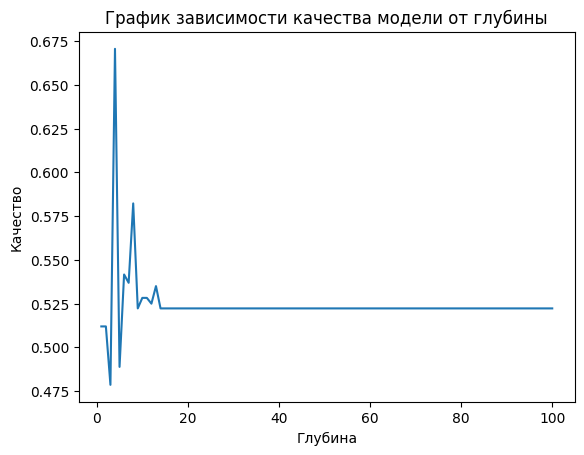

In [14]:
import matplotlib.pyplot as plt
f1s = []
depths = list(range(1, 101, 1))
best_depth = -1
best_f1 = 0
for max_depth in depths:
    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1s.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_depth = max_depth
plt.plot(depths, f1s)
plt.xlabel("Глубина")
plt.ylabel("Качество")
plt.title("График зависимости качества модели от глубины")
plt.show()

Лучшая модель получилось при глубине

In [16]:
print("Глубина:", best_depth, "F1:", best_f1)

Глубина: 4 F1: 0.6705882352941176


Таким образом мы уже получили модель с сильно лучшим качеством, по сравнению с логистической регрессией. 

Построим получившееся лучшее дерево

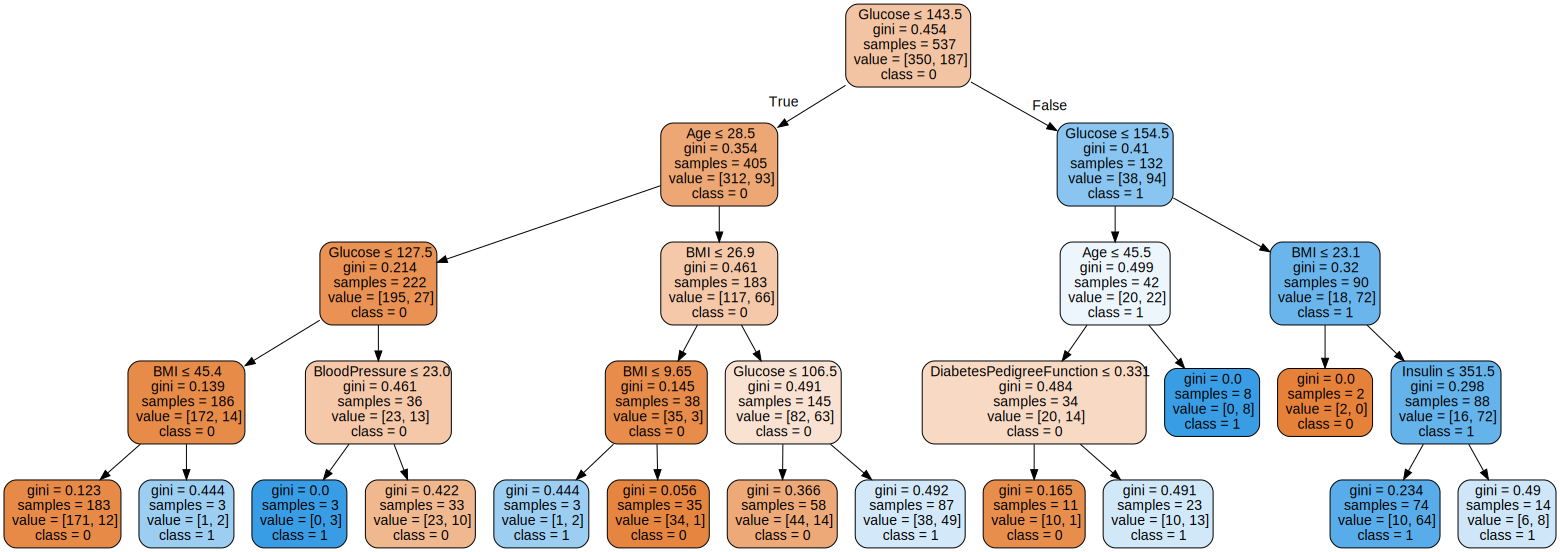

In [28]:
import graphviz
from sklearn import tree

best_tree = DecisionTreeClassifier(max_depth=best_depth)
best_tree.fit(X_train, y_train)
dot_data = tree.export_graphviz(best_tree, out_file=None, 
                     feature_names=data.columns[:-1],  
                     class_names=["0", "1"],  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

Построим диаграмму значимости признаков датасета

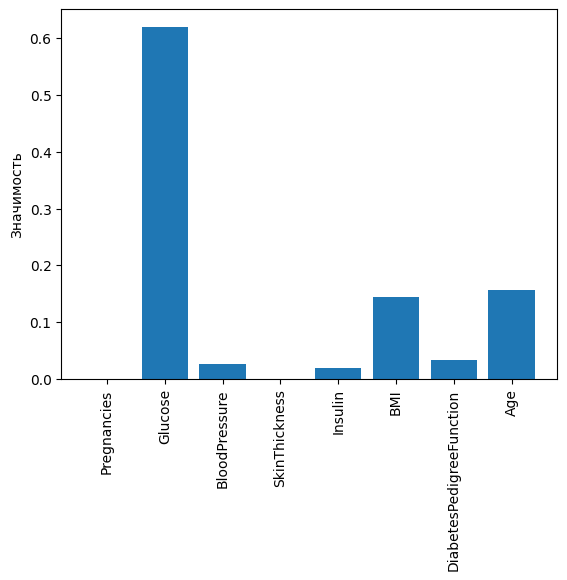

In [29]:
plt.bar(data.columns[:-1], best_tree.feature_importances_)
plt.ylabel("Значимость")
plt.tick_params(axis='x', rotation=90)

Построим PR и ROC кривые

In [30]:
from sklearn.metrics import precision_recall_curve, roc_curve
y_pred_probs = best_tree.predict_proba(X_test)[:, 1]

Text(0.5, 1.0, 'PR кривая')

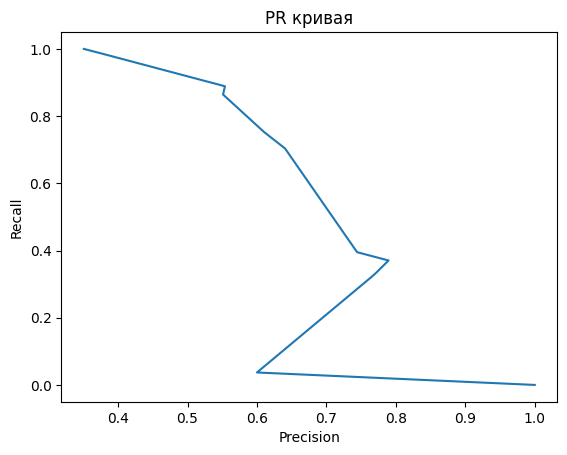

In [31]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
plt.plot(precision, recall)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("PR кривая")

Text(0.5, 1.0, 'ROC кривая')

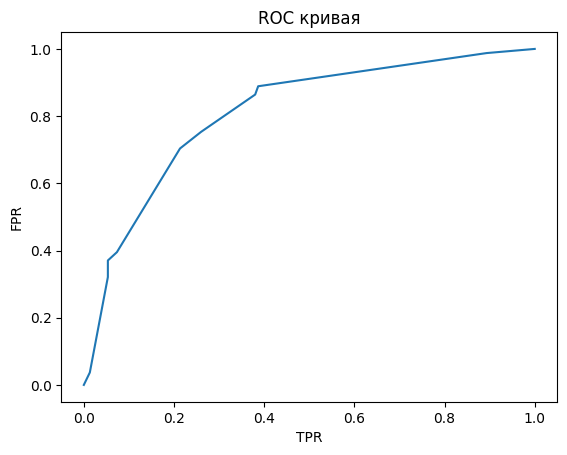

In [32]:
TPR, FPR, _ = roc_curve(y_test, y_pred_probs)
plt.plot(TPR, FPR)
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ROC кривая")

Исследуем качество модели в зависимости от максимального количества признаков max_features

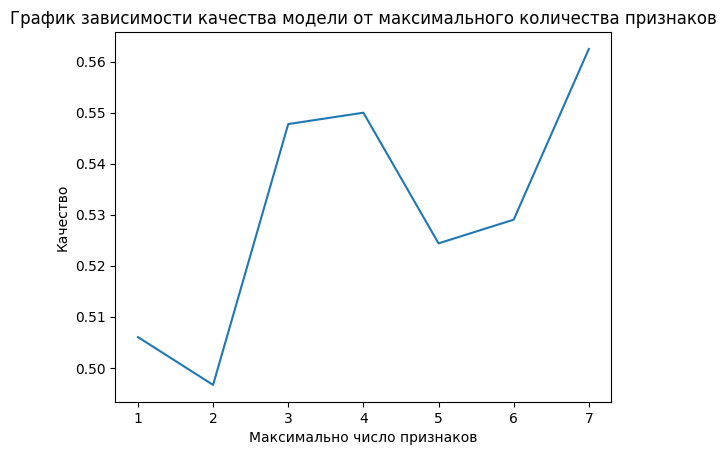

In [33]:
f1s = []
features = list(range(1, X.shape[1]))
for max_features in features:
    clf = DecisionTreeClassifier(max_features=max_features, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1s.append(f1_score(y_test, y_pred))
plt.plot(features, f1s)
plt.xlabel("Максимально число признаков")
plt.ylabel("Качество")
plt.title("График зависимости качества модели от максимального количества признаков")
plt.show()

Теперь от минимального числа объектов в листьях min_samples_split

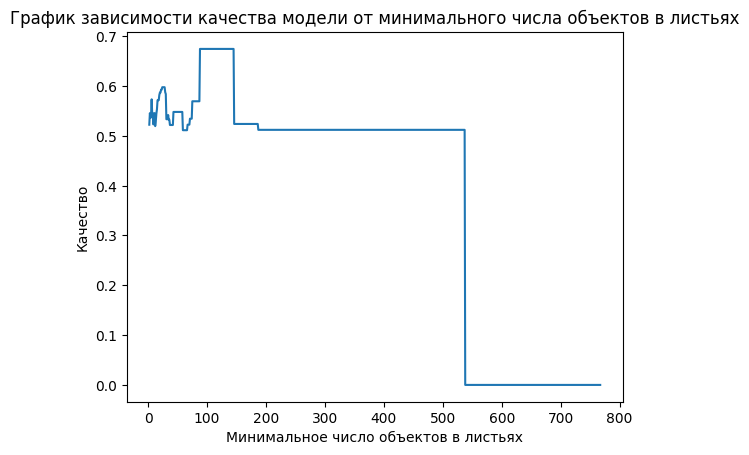

In [34]:
f1s = []
features = list(range(2, X.shape[0]))
for min_samples_split in features:
    clf = DecisionTreeClassifier(min_samples_split=min_samples_split, random_state=0)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1s.append(f1_score(y_test, y_pred))
plt.plot(features, f1s)
plt.xlabel("Минимальное число объектов в листьях")
plt.ylabel("Качество")
plt.title("График зависимости качества модели от минимального числа объектов в листьях")
plt.show()